In [1]:
"""
Idea for class-based snipper
kwargs in the init section so that pre, post, minrun, binlength etc can be given
Give it the data stream and start, stop is optional
baseline correction could have options
keeps original un-binned data allowing multiple binnings to be tried easily on the same object and multiple baselines etc
details of methods updated
"""

'\nIdea for class-based snipper\nkwargs in the init section so that pre, post, minrun, binlength etc can be given\nGive it the data stream and start, stop is optional\nbaseline correction could have options\nkeeps original un-binned data allowing multiple binnings to be tried easily on the same object and multiple baselines etc\ndetails of methods updated\n'

In [20]:
from pathlib import Path
from math import ceil, floor
import matplotlib.pyplot as plt
import trompy as tp
import numpy as np
import pickle
import pandas as pd
import seaborn as sns

In [21]:
DATAPATH = Path("C://Data//hislight_pickles//adlib_dark.pickle")

with open(DATAPATH, 'rb') as handle:
    restricted_dark = pickle.load(handle)

In [54]:
mouse_to_be_analyzed = "HL202"

In [55]:
restricted_dark.keys()

dict_keys(['HL202_7', 'HL203_7', 'HL204_7', 'HL205_7', 'HL206_7', 'HL207_7', 'HL208_7', 'HL209_7', 'HL210_7', 'HL211_7', 'HL212_7', 'HL202_8', 'HL203_8', 'HL204_8', 'HL205_8', 'HL206_8', 'HL207_8', 'HL208_8', 'HL209_8', 'HL210_8', 'HL211_8', 'HL212_8'])

In [62]:
d = restricted_dark["HL202_8"]

lickdata = tp.lickCalc(d["licks"], minrunlength=3)

In [63]:
lickdata.keys()

dict_keys(['licklength', 'longlicks', 'licks', 'ilis', 'freq', 'total', 'bStart', 'bInd', 'bEnd', 'bLicks', 'bNum', 'bTime', 'bMean', 'bMean-first3', 'IBIs', 'rStart', 'rInd', 'rEnd', 'rLicks', 'rTime', 'rNum', 'weib_alpha', 'weib_beta', 'weib_rsq', 'burstprob', 'hist'])

In [64]:
def put_snip_in_bins(snip, binlength, fs):
    bins = int(len(snip)/(fs*binlength))
    remainder_samples = len(snip) % bins

    return np.reshape(snip[:-remainder_samples], (bins, -1)).mean(axis=1)
    
def longsnipper(data, start, stop, fs, adjust_baseline=True, pre=10, post=10, minrun=10, binlength=0.1):
    #check if start and stop are same length
    # could do more checking in future, e.g. to see if all stop times come after start times
    if len(start) != len(stop):
        print("Start and stop arrays are different lengths. Exiting.")
        return None

    # converts start and stop times from seconds to samples
    run_start_in_samples = [ceil(x*fs) for x in start]
    run_stop_in_samples = [ceil(x*fs) for x in stop]

    # makes snips
    snips = []
    for start, stop in zip(run_start_in_samples, run_stop_in_samples):
        snips.append(data[start - int(pre*fs):stop + int(post*fs)])

    # adjusts baseline by subtracting the mean (not z-score)
    if adjust_baseline:
        adj_snips = []
        for snip in snips:
            baseline = np.mean(snip[:int(pre*fs)])
            adj_snips.append(np.subtract(snip, baseline))
        snips = adj_snips

    # removes short runs (by seconds)
    snips = [snip for snip in snips if len(snip) > (pre+post+minrun)*fs]

    # puts into bins if requested
    snips = [put_snip_in_bins(snip, binlength, fs) for snip in snips]

    return snips

snips = longsnipper(d["corrected"], lickdata["rStart"], lickdata["rEnd"], d["fs"])

In [65]:
run_length, run_licks, snips_long = [], [], []

pre=10
post=10
minrun=10
binlength=0.1

for key, val in restricted_dark.items():
    if val["mouse_ID"] == mouse_to_be_analyzed:
        lickdata= tp.lickCalc(val["licks"], minrunlength=3)
        fs = val["fs"]
        
        run_length.append(lickdata["rTime"])
        run_licks.append(lickdata["rLicks"])
       
        snips_long.append(longsnipper(val["corrected"], lickdata["rStart"], lickdata["rEnd"], val["fs"],
                                     pre=pre, post=post, minrun=minrun, binlength=binlength))

run_length = tp.flatten_list(run_length)
run_licks = tp.flatten_list(run_licks)
snips_long = tp.flatten_list(snips_long)


In [66]:
len(snips_long)
snips_long[0].shape

(344,)

<AxesSubplot:>

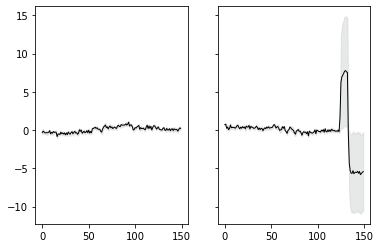

In [67]:
f, [ax1, ax2] = plt.subplots(ncols=2, sharey=True)

bins = int((pre + post + minrun) / binlength)
bins_per_section = int(bins/2)

tp.shadedError(ax1, np.array([snip[:bins_per_section] for snip in snips_long]))
tp.shadedError(ax2, np.array([snip[-bins_per_section:] for snip in snips_long]))

In [68]:
lickdata

{'licklength': array([], dtype=float64),
 'longlicks': None,
 'licks': array([ 575.95789312,  576.06193152,  618.13194752,  618.24008192,
         618.32921088,  618.40605184,  618.51303936,  618.6131456 ,
         618.72603136,  618.83908096,  618.94098944,  619.05108992,
         619.17396992,  619.28112128,  619.39712   ,  619.53097728,
         619.65910016,  619.68416768,  619.8009856 ,  619.90207488,
         620.00922624,  620.14521344,  620.2990592 ,  620.40457216,
         620.50828288,  620.63525888,  620.75600896,  620.89199616,
         621.01504   ,  621.1510272 ,  621.27505408,  621.4172672 ,
         621.531136  ,  621.67400448,  621.80409344,  621.95007488,
         622.06902272,  622.2061568 ,  622.3470592 ,  622.46731776,
         622.61510144,  622.74011136,  622.89412096,  623.04223232,
         623.18608384,  623.321088  ,  623.4841088 ,  623.6291072 ,
         623.74641664,  623.86208768,  624.00806912,  624.1312768 ,
         624.24317952,  624.36327424,  624.505

In [32]:
lickdata["rStart"]

[130.51461632000002,
 145.80678656,
 248.31328256,
 279.62753024,
 549.26409728,
 908.73544704,
 1660.02982912]

In [33]:
snipper=tp.Snipper(d["corrected"], lickdata["rStart"], lickfs=d["fs"], binlength=0.1)
#snipper.get_snips()
#snipper.plot_shaded_error(color="blue")

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:155: RuntimeWarning: Mean of empty slice.
  return np.reshape(snip[:-remainder_samples], (bins, -1)).mean(axis=1)
C:\Users\kvo019\Anaconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [34]:
snipper.snips

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [35]:
dir(snipper)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'adjust_baseline',
 'adjustbaseline',
 'baseline_end_in_samples',
 'baseline_start_in_samples',
 'baselinelength',
 'bin_snips',
 'binlength',
 'binned',
 'check_for_ragged_array',
 'check_snips_array',
 'data',
 'end',
 'events_in_samples',
 'fs',
 'get_snips',
 'kwargs',
 'longsnipper',
 'nsnips',
 'plot',
 'plot_heatmap',
 'plot_shaded_error',
 'post',
 'pre',
 'put_snip_in_bins',
 'remove_artifacts',
 'remove_artifacts_from_snips',
 'set_baseline',
 'snips',
 'start',
 'trial_end',
 'trial_length_in_samples',
 'trial_start',
 'truncate',
 'truncate_to_same_length',
 'zscore',
 'zscore_snips']

In [36]:
len(snips_long)

11

In [37]:
mice = []
for key, val in restricted_dark.items():
    if val["mouse_ID"] not in mice:
        mice.append(val["mouse_ID"])

In [38]:
mice

['HL202',
 'HL203',
 'HL204',
 'HL205',
 'HL206',
 'HL207',
 'HL208',
 'HL209',
 'HL210',
 'HL211',
 'HL212']

In [39]:
def truncate_snips_to_same_length(snips, bins_per_trial):

    snips_long_array = np.zeros((len(snips), bins_per_trial))
    bins_per_section = int(bins_per_trial/2)

    for idx, snip in enumerate(snips):
        snips_long_array[idx,:bins_per_section] = snip[:bins_per_section]
        snips_long_array[idx,-bins_per_section:] = snip[-bins_per_section:]

    return snips_long_array

def get_long_snips(d, mouse, minrun=10, binlength=0.1, pre=10, post=10, truncate_snips=True):

    run_length, run_licks, snips_long = [], [], []

    for key, val in d.items():
        if val["mouse_ID"] == mouse:
            lickdata= tp.lickCalc(val["licks"], minrunlength=3)
            
            run_length.append(lickdata["rTime"])
            run_licks.append(lickdata["rLicks"])
           
            snips_long.append(longsnipper(val["corrected"], lickdata["rStart"], lickdata["rEnd"], val["fs"], minrun=minrun, binlength=binlength, pre=pre, post=post))

    run_length = tp.flatten_list(run_length)
    run_licks = tp.flatten_list(run_licks)
    snips_long = tp.flatten_list(snips_long)

    print(len(snips_long))

    if truncate_snips:
        bins_per_trial = int((minrun + pre + post) / binlength)
        snips_long = truncate_snips_to_same_length(snips_long, bins_per_trial)

    return snips_long

kwargs = {"minrun": 10, "binlength": 0.1}

In [40]:
snips_long_all_mice = []
for mouse in mice:

    s = get_long_snips(restricted_dark, mouse, minrun=minrun, binlength=binlength, pre=pre, post=post)
    snips_long_all_mice.append(np.nanmean(s, axis=0))

snips_long_all_mice = np.array(snips_long_all_mice)


9
9
21
13
12
15
20
14
11
12
5


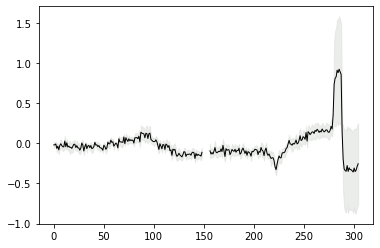

In [41]:
s = np.array(snips_long_all_mice)

f, ax = plt.subplots()
x1 = np.arange(0,149)
x2 = np.arange(156,305)

y1 = s[:,:149]
y2 = s[:,151:]

y1_mean = np.mean(y1, axis=0)
y2_mean = np.mean(y2, axis=0)

y1_err = np.std(y1, axis=0)/np.sqrt(y1.shape[0])
y2_err = np.std(y2, axis=0)/np.sqrt(y2.shape[0])

ax.plot(x1, y1_mean, color="k", linewidth=1, linestyle="-")
ax.fill_between(x1, y1_mean-y1_err, y1_mean+y1_err, color="xkcd:light grey", alpha=0.5)

ax.plot(x2, y2_mean, color="k", linewidth=1, linestyle="-")
ax.fill_between(x2, y2_mean-y2_err, y2_mean+y2_err, color="xkcd:light grey", alpha=0.5)

In [18]:
def add_whitegap_to_colormapdata(snip_array, nbins_in_gap=10):

    array1 = snip_array[:,:150]
    array2 = snip_array[:,150:]
    gap_array = np.zeros((snip_array.shape[0], nbins_in_gap))

    return np.hstack([array1, gap_array, array2])

colormap_s = add_whitegap_to_colormapdata(s)
colormap_s.shape

(11, 310)

<AxesSubplot:>

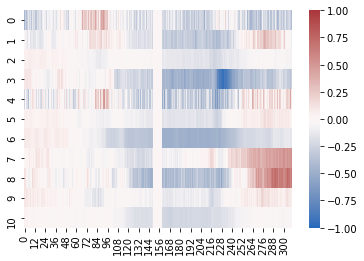

In [19]:
sns.heatmap(colormap_s, vmin=-1, vmax=1, cmap="vlag")

<AxesSubplot:>

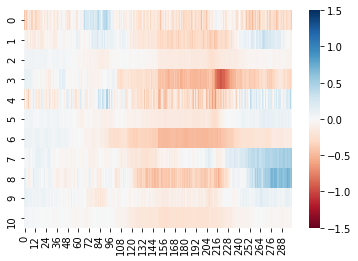

In [20]:
sns.heatmap(snips_long_all_mice, vmin=-1.5, vmax=1.5, cmap="RdBu")

In [21]:
len(snips_long_all_mice)

11

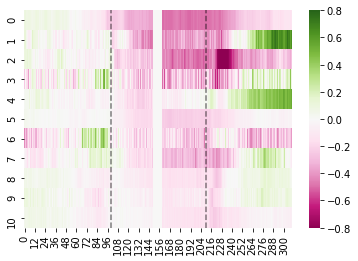

In [22]:
auc = np.mean(snips_long_all_mice[:,210:], axis=1) # auc calculated rebound at end (20-30 sec)
auc = np.mean(snips_long_all_mice[:,100:150], axis=1) # auc calculated from dip at start (10-15 sec)
sort_order = np.argsort(auc)

f, ax = plt.subplots()
sns.heatmap(add_whitegap_to_colormapdata(snips_long_all_mice[sort_order, :]), cmap="PiYG", vmin=-0.8, vmax=0.8,
           ax=ax)
ax.axvline(100, color="k", linestyle="--", alpha=0.5)
ax.axvline(210, color="k", linestyle="--", alpha=0.5)

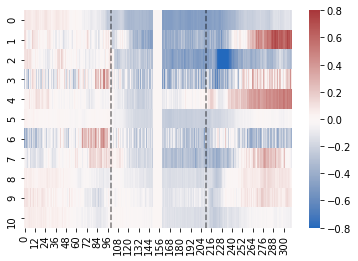

In [23]:
auc = np.mean(snips_long_all_mice[:,210:], axis=1) # auc calculated rebound at end (20-30 sec)
auc = np.mean(snips_long_all_mice[:,100:150], axis=1) # auc calculated from dip at start (10-15 sec)
sort_order = np.argsort(auc)

f, ax = plt.subplots()
sns.heatmap(add_whitegap_to_colormapdata(snips_long_all_mice[sort_order, :]), cmap="vlag", vmin=-0.8, vmax=0.8,
           ax=ax)
ax.axvline(100, color="k", linestyle="--", alpha=0.5)
ax.axvline(210, color="k", linestyle="--", alpha=0.5)